In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [ ]:
# Crear carpetas para resultados y figuras
import os
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Cargar datos
data_path = 'C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv'
data = pd.read_csv(data_path, sep=',')
print(data.shape)

# Separar características y variable objetivo
X = data.drop(columns=['y'])
y = data['y']

# Definir columnas numéricas
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Escalar columnas numéricas
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


(45211, 33)


In [3]:
# Aplicar SMOTEENN para balancear clases
smoteenn = SMOTEENN(random_state=42)
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)


In [4]:
# Selección de características con BorutaPy
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_resample.values, y_resample.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()
print(f"Selected features: {len(X_filtered)}")


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Selected features: 26


In [5]:
# Filtrar datos con las características seleccionadas
X_train_filtered = X_resample[X_filtered].values
X_test_filtered = X_test[X_filtered].values
y_train_filtered = y_resample.values
y_test_filtered = y_test.values

In [ ]:
# Parámetros de la red neuronal
input_size = len(X_filtered)
hidden_units = 64
hidden_layers = 2
dropout_rate = 0.2
learning_rate = 0.0001
epochs = 50
n_iterations = 5

# Definir valores a probar para cada parámetro
num_microbatches_values = [4, 8, 16, 32]
l2_norm_clip_values = [0.1, 1, 1.5, 2]
noise_multiplier_values = [1.1, 1.5, 2.0, 2.5]

batch_size = [32] # TODO: Probar diferentes tamaños de batch

# TODO: Probar diferentes tamaños de la muestra
sample_size_ratio = [1, 0.9, 0.8, 0.7, 0.6]

# Valores fijos por defecto
default_num_microbatches = 32
default_l2_norm_clip = 1.0
default_noise_multiplier = 1.1


In [ ]:
# Función para calcular el presupuesto de privacidad
def compute_privacy_budget(n, batch_size, noise_multiplier, epochs, delta=1e-5):
    try:
        eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=n, batch_size=batch_size, noise_multiplier=noise_multiplier,
            epochs=epochs, delta=delta
        )[0]
        return eps
    except Exception as e:
        print(f"Error al calcular el presupuesto de privacidad: {e}")
        return float('inf')

# Definir la red neuronal con tf.keras
def create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=False,
                 num_microbatches=default_num_microbatches, l2_norm_clip=default_l2_norm_clip,
                 noise_multiplier=default_noise_multiplier):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_size,)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    if use_dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Función para entrenar el modelo
def train_model(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=False,
                num_microbatches=default_num_microbatches, l2_norm_clip=default_l2_norm_clip,
                noise_multiplier=default_noise_multiplier):
    model = create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=use_dp,
                         num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
                         noise_multiplier=noise_multiplier)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test)
    )
    
    y_pred_prob_test = model.predict(X_test, batch_size=batch_size).flatten()
    y_pred_test = (y_pred_prob_test > 0.4).astype(int)
    
    return y_pred_prob_test, y_pred_test

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_prob):
    conf_matrix = confusion_matrix(y_true, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_rate = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_rate = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Type I Error': false_positive_rate,
        'Type II Error': false_negative_rate
    }

# Función para ejecutar múltiples iteraciones y calcular estadísticas
def run_iterations(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp, n_iterations,
                   num_microbatches, l2_norm_clip, noise_multiplier):
    results = []
    for _ in range(n_iterations):
        y_pred_prob_test, y_pred_test = train_model(
            X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=use_dp,
            num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier
        )
        result = evaluate_model(y_test, y_pred_test, y_pred_prob_test)
        results.append(result)
    return pd.DataFrame(results)

# Función para calcular estadísticas
def compute_statistics(df):
    stats = {
        'mean': df.mean(),
        'min': df.min(),
        'max': df.max()
    }
    return stats
    

In [18]:
# Entrenar modelo sin DP (como en el código original)
print("Entrenando modelo sin DP...")
results_no_dp = run_iterations(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
    batch_size, epochs, use_dp=False, n_iterations=n_iterations,
    num_microbatches=None, l2_norm_clip=None, noise_multiplier=None
)
results_no_dp_stats = compute_statistics(results_no_dp)

Entrenando modelo sin DP...
Epoch 1/50
1672/1672 [==============================] - 1s 637us/step - loss: 0.5697 - accuracy: 0.7050 - val_loss: 0.5909 - val_accuracy: 0.6756
Epoch 2/50
1672/1672 [==============================] - 1s 597us/step - loss: 0.4549 - accuracy: 0.7859 - val_loss: 0.5288 - val_accuracy: 0.7390
Epoch 3/50
1672/1672 [==============================] - 1s 499us/step - loss: 0.3759 - accuracy: 0.8384 - val_loss: 0.4949 - val_accuracy: 0.7909
Epoch 4/50
1672/1672 [==============================] - 1s 517us/step - loss: 0.3129 - accuracy: 0.8768 - val_loss: 0.4762 - val_accuracy: 0.8172
Epoch 5/50
1672/1672 [==============================] - 1s 493us/step - loss: 0.2818 - accuracy: 0.8915 - val_loss: 0.4682 - val_accuracy: 0.8219
Epoch 6/50
1672/1672 [==============================] - 1s 592us/step - loss: 0.2672 - accuracy: 0.8986 - val_loss: 0.4891 - val_accuracy: 0.8113
Epoch 7/50
1672/1672 [==============================] - 1s 476us/step - loss: 0.2588 - accuracy:

In [8]:
# Ejecutar experimentos variando un parámetro a la vez
n = len(X_train_filtered)
delta = 1e-5

In [9]:
# 1. Variar num_microbatches
results_num_microbatches = {}
eps_num_microbatches = {}
for nm in num_microbatches_values:
    print(f"\nEntrenando modelo con num_microbatches={nm}...")
    eps = compute_privacy_budget(n, batch_size, default_noise_multiplier, epochs, delta)
    results = run_iterations(
        X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
        batch_size, epochs, use_dp=True, n_iterations=n_iterations,
        num_microbatches=nm, l2_norm_clip=default_l2_norm_clip,
        noise_multiplier=default_noise_multiplier
    )
    results_num_microbatches[nm] = compute_statistics(results)
    eps_num_microbatches[nm] = eps



Entrenando modelo con num_microbatches=4...
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.1 iterated over 83600 steps satisfies differential privacy with eps = 1.06 and delta = 1e-05.
The optimal RDP order is 17.0.
Epoch 1/50
1672/1672 [==============================] - 1s 514us/step - loss: 0.7372 - accuracy: 0.4603 - val_loss: 0.7075 - val_accuracy: 0.3656
Epoch 2/50
1672/1672 [==============================] - 1s 538us/step - loss: 0.7106 - accuracy: 0.4782 - val_loss: 0.7299 - val_accuracy: 0.2497
Epoch 3/50
1672/1672 [==============================] - 1s 463us/step - loss: 0.7038 - accuracy: 0.4959 - val_loss: 0.7257 - val_accuracy: 0.2735
Epoch 4/50
1672/1672 [==============================] - 1s 463us/step - loss: 0.6983 - accuracy: 0.5099 - val_loss: 0.7163 - val_accuracy: 0.3612
Epoch 5/50
1672/1672 [==============================] - 1s 460us/step - loss: 0.6921 - accuracy: 0.5273 - val_loss: 0.7146 - val_accuracy: 0.4150
Epoch 6/50
1672/1672 [=================

In [10]:
# 2. Variar l2_norm_clip
results_l2_norm_clip = {}
eps_l2_norm_clip = {}
for l2 in l2_norm_clip_values:
    print(f"\nEntrenando modelo con l2_norm_clip={l2}...")
    eps = compute_privacy_budget(n, batch_size, default_noise_multiplier, epochs, delta)
    results = run_iterations(
        X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
        batch_size, epochs, use_dp=True, n_iterations=n_iterations,
        num_microbatches=default_num_microbatches, l2_norm_clip=l2,
        noise_multiplier=default_noise_multiplier
    )
    results_l2_norm_clip[l2] = compute_statistics(results)
    eps_l2_norm_clip[l2] = eps



Entrenando modelo con l2_norm_clip=0.5...
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.1 iterated over 83600 steps satisfies differential privacy with eps = 1.06 and delta = 1e-05.
The optimal RDP order is 17.0.
Epoch 1/50
1672/1672 [==============================] - 1s 529us/step - loss: 0.7128 - accuracy: 0.5278 - val_loss: 0.7158 - val_accuracy: 0.4483
Epoch 2/50
1672/1672 [==============================] - 1s 496us/step - loss: 0.6946 - accuracy: 0.5413 - val_loss: 0.6999 - val_accuracy: 0.5145
Epoch 3/50
1672/1672 [==============================] - 1s 488us/step - loss: 0.6868 - accuracy: 0.5527 - val_loss: 0.6903 - val_accuracy: 0.5469
Epoch 4/50
1672/1672 [==============================] - 1s 474us/step - loss: 0.6819 - accuracy: 0.5635 - val_loss: 0.6970 - val_accuracy: 0.5232
Epoch 5/50
1672/1672 [==============================] - 1s 482us/step - loss: 0.6759 - accuracy: 0.5737 - val_loss: 0.6880 - val_accuracy: 0.5535
Epoch 6/50
1672/1672 [===================

In [11]:
# 3. Variar noise_multiplier
results_noise_multiplier = {}
eps_noise_multiplier = {}
for noise in noise_multiplier_values:
    print(f"\nEntrenando modelo con noise_multiplier={noise}...")
    eps = compute_privacy_budget(n, batch_size, noise, epochs, delta)
    results = run_iterations(
        X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
        batch_size, epochs, use_dp=True, n_iterations=n_iterations,
        num_microbatches=default_num_microbatches, l2_norm_clip=default_l2_norm_clip,
        noise_multiplier=noise
    )
    results_noise_multiplier[noise] = compute_statistics(results)
    eps_noise_multiplier[noise] = eps



Entrenando modelo con noise_multiplier=1.1...
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.1 iterated over 83600 steps satisfies differential privacy with eps = 1.06 and delta = 1e-05.
The optimal RDP order is 17.0.
Epoch 1/50
1672/1672 [==============================] - 2s 1ms/step - loss: 0.7683 - accuracy: 0.5300 - val_loss: 0.7930 - val_accuracy: 0.1406
Epoch 2/50
1672/1672 [==============================] - 2s 1ms/step - loss: 0.6776 - accuracy: 0.5782 - val_loss: 0.7175 - val_accuracy: 0.4419
Epoch 3/50
1672/1672 [==============================] - 2s 1ms/step - loss: 0.6678 - accuracy: 0.6075 - val_loss: 0.7064 - val_accuracy: 0.4884
Epoch 4/50
1672/1672 [==============================] - 2s 993us/step - loss: 0.6610 - accuracy: 0.6209 - val_loss: 0.6929 - val_accuracy: 0.5294
Epoch 5/50
1672/1672 [==============================] - 2s 1ms/step - loss: 0.6561 - accuracy: 0.6289 - val_loss: 0.6884 - val_accuracy: 0.5427
Epoch 6/50
1672/1672 [=======================

In [12]:
# Guardar resultados en un CSV
results_stats = {
    'num_microbatches': results_num_microbatches,
    'l2_norm_clip': results_l2_norm_clip,
    'noise_multiplier': results_noise_multiplier
}
data = {}
for param, stats_dict in results_stats.items():
    for value, stats in stats_dict.items():
        model = f'{param}={value} (ε={eps_num_microbatches.get(value, eps_l2_norm_clip.get(value, eps_noise_multiplier[value])):.2f})'
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']
results_df = pd.DataFrame(data).round(4)
results_df.to_csv('results/CDP_parameter_results.csv')
print("\nResultados guardados en 'results/CDP_parameter_results.csv'")
print("\nResultados (Promedios):\n", results_df[[col for col in results_df.columns if 'mean' in col]])


KeyError: 4

In [15]:
# Función para graficar resultados, incluyendo el modelo sin DP
def plot_parameter_results(stats_dict, eps_dict, param_name, colors, no_dp_stats):
    metrics = list(no_dp_stats['mean'].keys())
    values = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_values = len(values) + 1  # +1 para incluir No DP
    
    plt.figure(figsize=(12, 6))
    x_positions = np.arange(n_metrics)
    
    # Primero, graficar el modelo sin DP (No DP)
    means = []
    mins = []
    maxs = []
    for metric in metrics:
        means.append(no_dp_stats['mean'][metric])
        mins.append(no_dp_stats['min'][metric])
        maxs.append(no_dp_stats['max'][metric])
    
    plt.scatter(x_positions + (0 - (n_values-1)/2) * 0.15, means, 
                color=colors[0], label='No DP', s=100)
    for metric_idx in range(n_metrics):
        plt.vlines(x_positions[metric_idx] + (0 - (n_values-1)/2) * 0.15, 
                   mins[metric_idx], maxs[metric_idx], 
                   color=colors[0], linestyle='-', linewidth=1)
    
    # Luego, graficar los resultados variando el parámetro
    for value_idx, value in enumerate(values, start=1):  # start=1 para saltar el color azul
        means = []
        mins = []
        maxs = []
        for metric in metrics:
            means.append(stats_dict[value]['mean'][metric])
            mins.append(stats_dict[value]['min'][metric])
            maxs.append(stats_dict[value]['max'][metric])
        
        plt.scatter(x_positions + (value_idx - (n_values-1)/2) * 0.15, means, 
                    color=colors[value_idx], label=f'{param_name}={value} (ε={eps_dict[value]:.2f})', s=100)
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (value_idx - (n_values-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[value_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45)
    plt.title(f'Effect of Varying {param_name} on Model Performance')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.legend(title=f'{param_name} Values', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'figures/Effect_of_{param_name}_with_No_DP.jpg', dpi=300, bbox_inches='tight')
    plt.show()

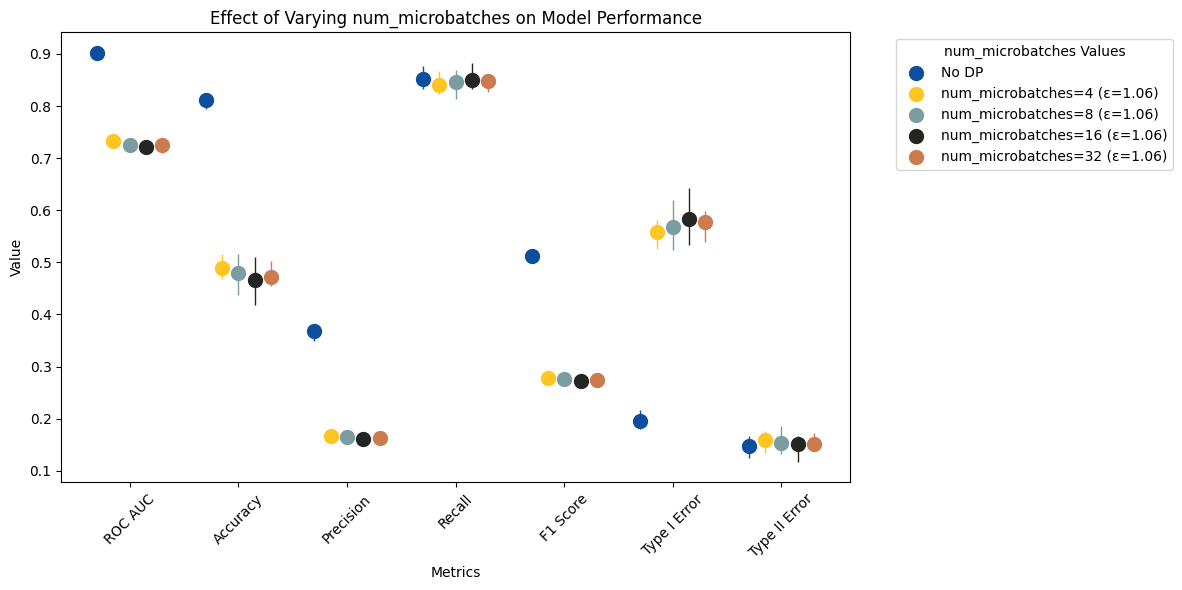

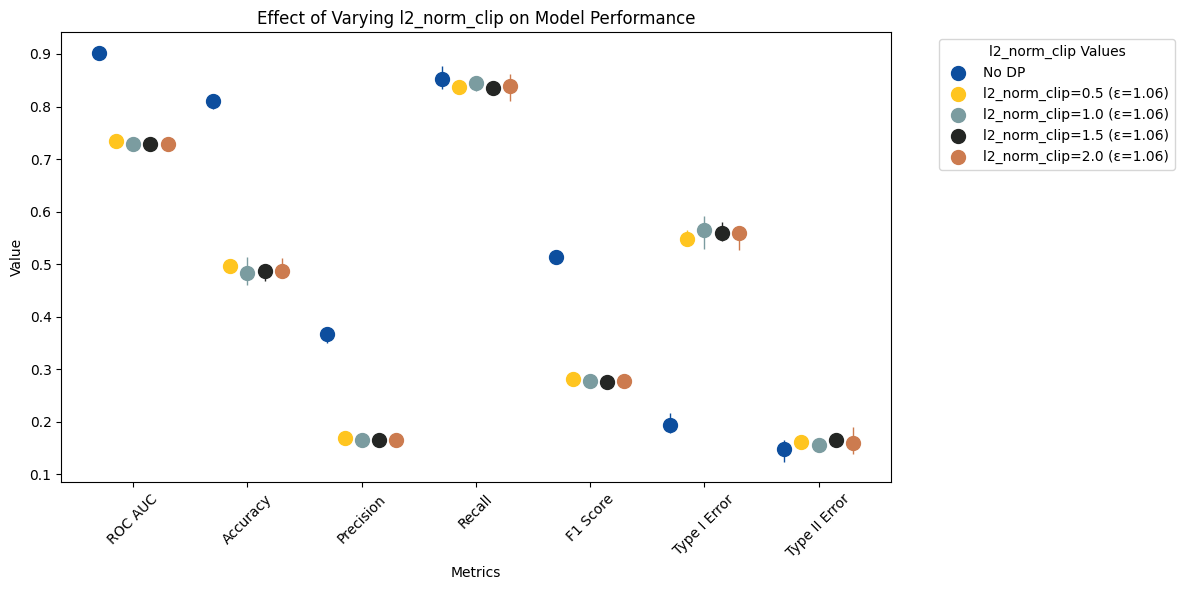

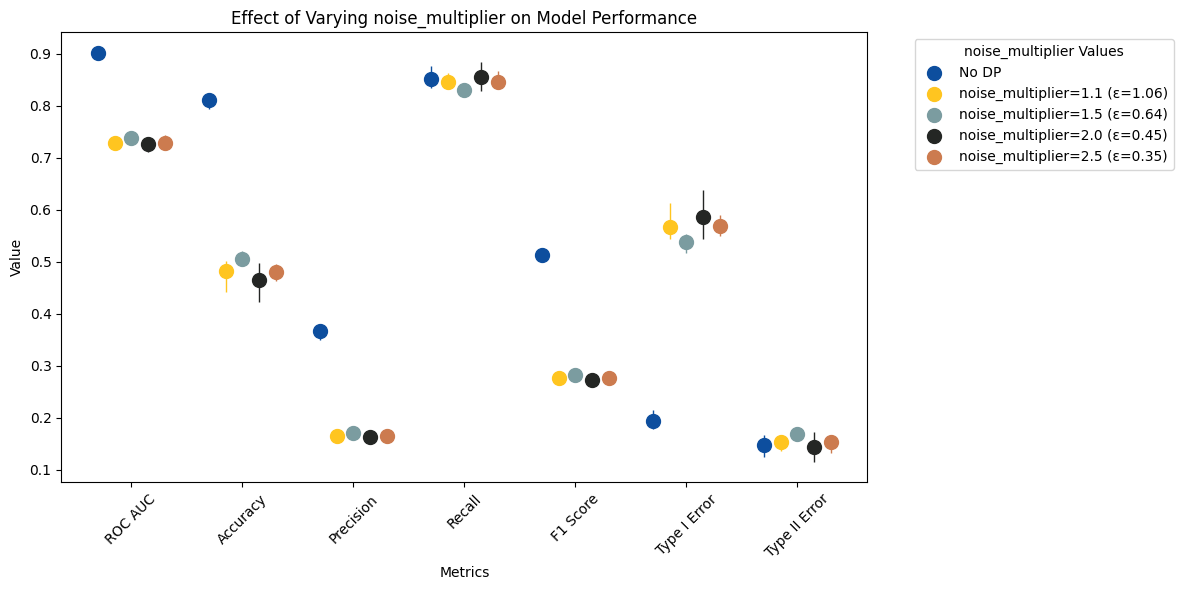

In [19]:
# Definir colores para cada valor de los parámetros
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f'] #, '#7764B4'

# Graficar resultados para cada parámetro
plot_parameter_results(results_num_microbatches, eps_num_microbatches, 'num_microbatches', colors, results_no_dp_stats)
plot_parameter_results(results_l2_norm_clip, eps_l2_norm_clip, 'l2_norm_clip', colors, results_no_dp_stats)
plot_parameter_results(results_noise_multiplier, eps_noise_multiplier, 'noise_multiplier', colors, results_no_dp_stats)
